Y-DATA 2020/21<br />
NLP HW1<br />
Serge Tochilov

# Predicting Sentence Similarity

In the first lecture we learned several techniques for sentence embedding. The most simple one which also leads to competitive results is simply taking an average of pre-trained word embeddings. In the present exercise we will explore the STS dataset (from the `datasets-sts` repo: https://github.com/brmson/dataset-sts) and see how existing word embeddings can be improved to better handle sentence embeddings.

## Package installation

For some methods below we also need word frequencies estimated from the corpus. As they're currently not available for the GloVe pretrained vectors / Common Crawl corpus, we'll employ the `wordfreq` package (https://github.com/LuminosoInsight/wordfreq/).

The STS dataset contains sentence pairs, and their corresponding similarity score based on human judgments. Additionally, we use word embeddings from the GloVe (Global Vectors for Word Representation, https://nlp.stanford.edu/projects/glove/) dataset with word vectors trained on the $840$ billion token Common Crawl corpus: http://nlp.stanford.edu/data/glove.840B.300d.zip. Please note that downloading may take a while.

In [ ]:
!pip install wordfreq
!git clone https://github.com/brmson/dataset-sts
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

     |████████████████████████████████| 56.9MB 75kB/s 
     |████████████████████████████████| 174kB 42.3MB/s 
     |████████████████████████████████| 727kB 22.2MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.5.0-cp37-none-any.whl size=56830860 sha256=10f13c8508d0728df741649dc6cac318413e7cdedd72889f3f240d76f0801818
  Stored in directory: /root/.cache/pip/wheels/b0/57/ab/4e4c8686c903dc68d3f405b5c8090218fdd2fd3997b86c8a47
  Created wheel for langcodes: filename=langcodes-3.1.0-cp37-none-any.whl size=165888 sha256=272bb74fad3c896677d777940a2d01484c124e954e040411d1c986769fbfe722
  Stored in directory: /root/.cache/pip/wheels/78/57/10/167a0f1c07409a7b72d8d08391fa9739ef37e834695575ccc8
Successfully built wordfreq langcodes
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
Cloning into 'dataset-sts'...
remote: Enumerating objects: 3477, done.
remote: Total 3477 (delta 0), reused 0 (delta 0), pack-reused 3

We convert the downloaded word embeddings to a dictionary.

In [ ]:
import pandas as pd
import zipfile

z = zipfile.ZipFile('./glove.840B.300d.zip')
glove_pd = pd.read_csv(z.open('glove.840B.300d.txt'),
    sep=' ', quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in glove_pd.T.items()}
del glove_pd

In [ ]:
glove['test']

array([ 6.1149e-02,  2.6721e-01,  2.1774e-01, -8.3348e-02, -2.6133e-01,
       -3.9486e-01,  1.5583e-01,  6.6879e-02,  2.0870e-01,  1.4234e+00,
       -1.0804e-02, -1.9882e-01,  3.9469e-01,  1.5281e-01, -5.3483e-02,
       -1.5038e-01,  7.6048e-02,  2.3503e+00, -5.4424e-01,  6.6730e-02,
        2.7928e-01,  1.9309e-02,  1.9913e-01,  1.5012e-01,  6.7792e-02,
        4.2240e-01,  6.4592e-02, -4.2206e-01,  3.6131e-01, -6.6089e-02,
       -8.7619e-03, -1.6498e-01,  1.0331e+00,  7.3610e-03,  4.9780e-02,
        3.5465e-01, -4.8489e-02,  4.3285e-01, -2.8666e-01,  1.7611e-02,
        3.6812e-01, -3.9362e-01, -1.2477e-02,  5.7482e-02,  1.1698e-01,
       -1.9191e-01, -3.2016e-02,  4.5280e-01,  1.8469e-01,  9.2373e-03,
        2.8163e-02, -7.1910e-02, -8.1790e-02, -2.2027e-01, -4.2260e-01,
       -1.5531e-02,  1.2467e-03, -1.1923e-01, -1.1214e-03, -8.8915e-02,
        1.1482e-01,  2.2836e-01,  2.0428e-02,  6.8038e-01,  5.8773e-01,
        5.3019e-01,  2.3912e-01, -3.6659e-01,  3.6670e-02,  5.14

If we want to get the frequency of a specific word it can be done easily with `wordfreq`. Note that in general, it would be better to calculate the word frequency based on a custom corpus.

In [ ]:
import wordfreq

wordfreq.word_frequency('test', 'en', wordlist='large')

0.000155

##Loading the datasets

In [ ]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import sys
sys.path.append('./dataset-sts/')
import pysts
from pysts.loader import load_sts

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Now we load 2015 headlines segment from the STS dataset. As you may see, each example consists of two sentences `s0`, `s1`, and a label.

In [ ]:
s0, s1, labels = load_sts('dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv')

In [ ]:
print(f'Sentence A: {s0[0]}')
print(f'Sentence B: {s1[0]}')
print(f'Label: {labels[0]}')

Sentence A: ['The', 'foundations', 'of', 'South', 'Africa', 'are', 'built', 'on', 'Nelson', 'Mandela', "'s", 'memory']
Sentence B: ['Australian', 'politicians', 'lament', 'over', 'Nelson', 'Mandela', "'s", 'death']
Label: 1.3



##Predict similarity between sentences based on GloVe

To predict similarity between two sentences, the word embeddings (using the GloVe word vectors) are combined into a sentence embedding. Similarity is calculated as the cosine similarity of two sentence embeddings, and overall performance is evaluated by Pearson's coefficient between the predicted scores and the labels.

Implement the following functions:
- Given a sentence, returns an average of its word embedding
- Given two sentence embeddings, returns their cosine-similarity
- Given predicted scores and labels, returns Pearson's r-coefficent

Tip: For calculating Pearson's r-coefficent you can employ `from scipy.stats import pearsonr`.

In [ ]:
from scipy.stats import pearsonr


# zero placeholder for words absent in GloVe
zeros = np.zeros_like(glove['test'])


def sent_embeds(sent):
    ''' Retrieve word embeddings to `embeds` '''

    tokens = nltk.word_tokenize(' '.join(sent).lower())

    if len(tokens) < 1:
        raise ValueError(f'sentence {sent} is empty')

    tokens, embeds = zip(*[(w, glove[w]) for w in tokens if w in glove])
    return tokens, embeds


def sent_avg_embed(sent):
    ''' Computes average sentence embedding '''

    _, embeds = sent_embeds(sent)
    return np.mean(embeds, axis=0)


def sent_cos_sim(e0, e1):
    ''' Computes cosine similarity for dim 1 (rows to rows) '''

    # # np.einsum() to compute np.dot() row-wise
    # return np.einsum('ij,ij->i', e0, e1) / (
    #     np.linalg.norm(e0, axis=1) * np.linalg.norm(e1, axis=1))

    return [np.dot(ea, eb)/(np.linalg.norm(ea) * np.linalg.norm(eb)) for ea, eb in zip(e0, e1)]


def sent_r(scores, labels):
    return pearsonr(scores, labels)[0]

You can check the implementation using a small subset of the data.

In [ ]:
def dataset_r(s0, s1, labels, embed_func, svd_func):
    ''' Computes Pearson's r-value for a batch of `s0`, `s1`, `labels`.
        embed_func() should compute sentence embedding,
        svd_func() should implement 1st common component removal. '''

    # sentence dim 0, embedding dim 1
    embed_s0 = svd_func([embed_func(s) for s in s0])
    embed_s1 = svd_func([embed_func(s) for s in s1])
    return sent_r(sent_cos_sim(embed_s0, embed_s1), labels)
    
n_batch = 10
small_batch = s0[:n_batch], s1[:n_batch], labels[:n_batch]
dataset_r(*small_batch, sent_avg_embed, lambda x: x)

0.731704900331293

Now we will evaluate the method across all the STS datasets using the following function which loops over all the datasets. The required output is a table which shows Pearson's coefficient on each dataset.

In [ ]:
files = glob.glob('dataset-sts/data/sts/semeval-sts/all/*.test.tsv')


def evaluate_tasks(files, embed_func, svd_func=(lambda x: x)):

    tests, scores = [], []

    for f in files:

        s0, s1, labels = load_sts(f)

        # your implementation here
        tests.append(f)
        scores.append(dataset_r(s0, s1, labels, embed_func, svd_func))

    return tests, scores

df = pd.DataFrame()
df['tests'], df['scores_avg'] = evaluate_tasks(files, sent_avg_embed)

In [ ]:
df['tests'] = (
    df['tests']
    .str.split('/')
    .apply(lambda x: x[-1])
    .str.slice(start=0, stop=-9))
display(df)

,tests,scores_avg
0,2013.headlines,0.632362
1,2014.images,0.624114
2,2016.headlines,0.611031
3,2015,0.435310
4,2012.SMTeuroparl,0.411691
5,2015.belief,0.441048
6,2014.headlines,0.593523
7,2016.plagiarism,0.537784
8,2013.FNWN,0.380082
9,2013.OnWN,0.471336


##Predict similarity between sentences based on Inverse-Frequency weighted GloVe

Now we'll see how we can improve our embeddings using Inverse-Frequency weighted average. Instead of taking a regular average we will take an average weighted by the word's inverse frequency.

We remind you that the word frequency can be calculated using the `wordfreq` package. As before, the final result should be a table with the calculated Pearson's coefficient. Place the result from this section next to the previous results, so we can spot the difference.

TIP: In order to avoid numerical issues instead of multiplying by `1/freq` you should multiply by `a/(a+freq)` with some small `a` (e.g., $0.001$).

In [ ]:
# your implementation here

a = 1e-3


def sent_avg_embed_if(sent):

    tokens, embeds = sent_embeds(sent)

    # compute inverse word frequencies
    iwf = a / (a +
        np.array([wordfreq.word_frequency(token, 'en', wordlist='large') for token in tokens]))
    
    # return IF-weighted average embeddings
    return np.average(embeds, axis=0, weights=iwf)
    

_, df['scores_avg_if'] = evaluate_tasks(files, sent_avg_embed_if)
display(df)

,tests,scores_avg,scores_avg_if
0,2013.headlines,0.632362,0.660314
1,2014.images,0.624114,0.763465
2,2016.headlines,0.611031,0.653568
3,2015,0.435310,0.578706
4,2012.SMTeuroparl,0.411691,0.481038
5,2015.belief,0.441048,0.559907
6,2014.headlines,0.593523,0.617922
7,2016.plagiarism,0.537784,0.700478
8,2013.FNWN,0.380082,0.398851
9,2013.OnWN,0.471336,0.652485


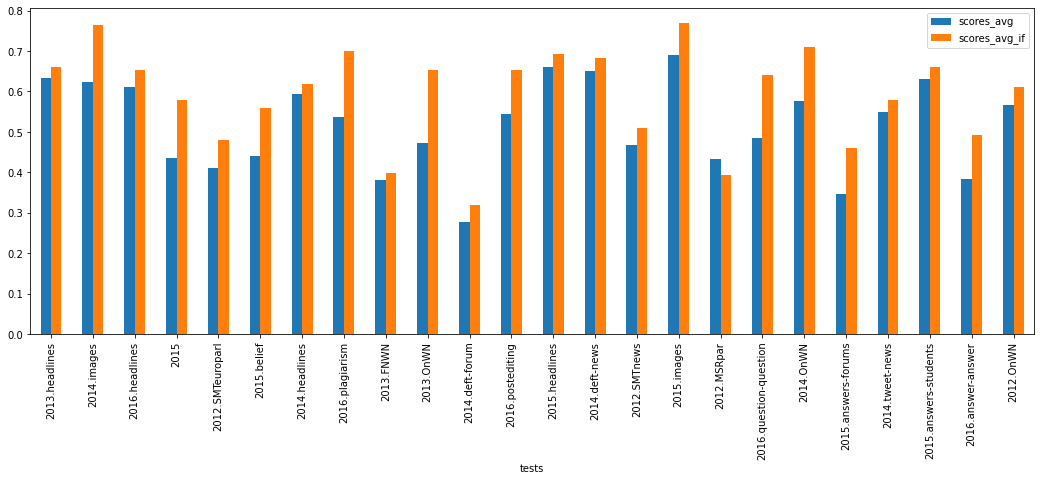

In [ ]:
df.plot.bar(x='tests', rot=90, figsize=(18, 6))

##Question

Does this method improve the first approach? If yes why?

> The IF-weighted averaging significantly improved the r-values, except for `2012.MSRpar` dataset, which is probably highly domain specific. IF-weighted averaging improves the similarity score by assigning more weight to less frequent words which may be better similarity discriminators than more common ones.

##Predict similarity between sentences based on first common component removal

Removal of the first common components is done as follows.

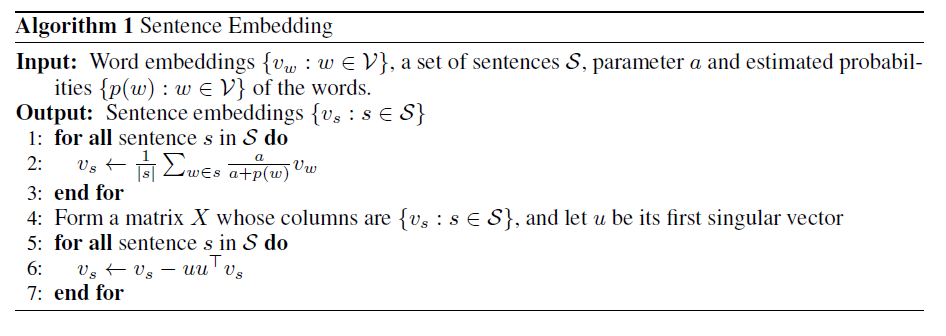

You may see that we've already implemented lines $1$-$3$, so we have to implement lines $4$-$6$ in the above algorithm. Again, place the result from this section next to the previous results.

In [ ]:
# your implementation here
from sklearn.decomposition import TruncatedSVD


def svd_remove(embed, n_first=1):

    svd = TruncatedSVD(n_components=100, random_state=65535)

    # first singular value(s) for embeddings
    comp_0 = svd.fit_transform(embed)[:, :n_first]

    # subtract embedding projections to first singular vector(s)
    return (embed - comp_0 @ svd.components_[:n_first])


_, df['scores_avg_if_svd'] = evaluate_tasks(files, sent_avg_embed_if, svd_remove)
display(df)

,tests,scores_avg,scores_avg_if,scores_avg_if_svd
0,2013.headlines,0.632362,0.660314,0.704721
1,2014.images,0.624114,0.763465,0.830084
2,2016.headlines,0.611031,0.653568,0.699653
3,2015,0.435310,0.578706,0.692900
4,2012.SMTeuroparl,0.411691,0.481038,0.491177
5,2015.belief,0.441048,0.559907,0.732140
6,2014.headlines,0.593523,0.617922,0.656922
7,2016.plagiarism,0.537784,0.700478,0.784836
8,2013.FNWN,0.380082,0.398851,0.426765
9,2013.OnWN,0.471336,0.652485,0.811437


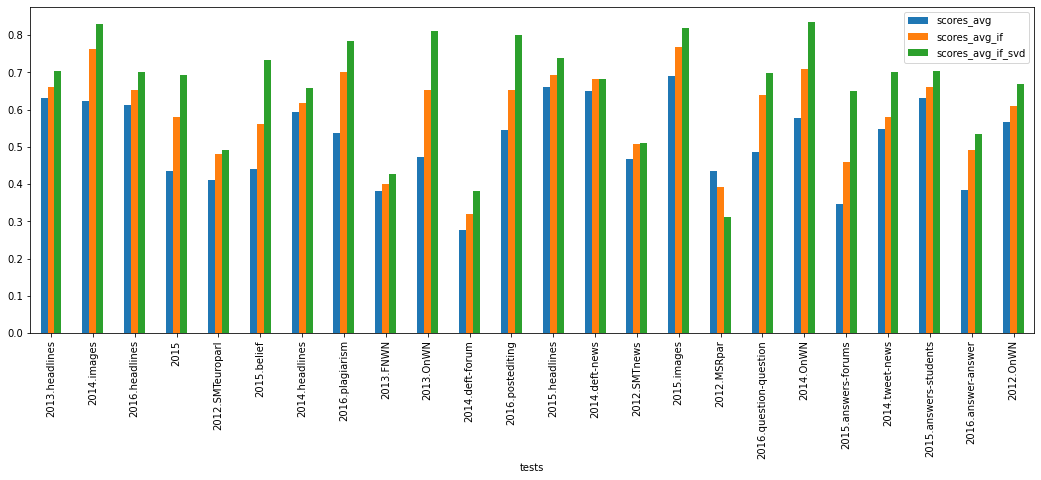

In [ ]:
df.plot.bar(x='tests', rot=90, figsize=(18, 6))

## Final Question

Please provide an explanation of why the method above works.


> Again the r-values significantly improved, except for `2012.MSRpar` dataset as usual, and also `2014.deft-news` marginally deteriorated. Subtracting the first common component after the IF-weighted averaging improves the similarity score by removing variations related to syntax, which is less relevant semantically.

> We tried to remove second common component also, but it didn't improve the result much, and for several datasets the r-value even became worse.

In [ ]:
def svd_remove_2(embed):
    return svd_remove(embed, n_first=2)


_, df['scores_avg_if_svd_2'] = evaluate_tasks(files, sent_avg_embed_if, svd_remove_2)
display(df)

,tests,scores_avg,scores_avg_if,scores_avg_if_svd,scores_avg_if_svd_2
0,2013.headlines,0.632362,0.660314,0.704721,0.720334
1,2014.images,0.624114,0.763465,0.830084,0.819865
2,2016.headlines,0.611031,0.653568,0.699653,0.704351
3,2015,0.435310,0.578706,0.692900,0.702351
4,2012.SMTeuroparl,0.411691,0.481038,0.491177,0.499312
5,2015.belief,0.441048,0.559907,0.732140,0.732080
6,2014.headlines,0.593523,0.617922,0.656922,0.663629
7,2016.plagiarism,0.537784,0.700478,0.784836,0.747465
8,2013.FNWN,0.380082,0.398851,0.426765,0.486812
9,2013.OnWN,0.471336,0.652485,0.811437,0.826487


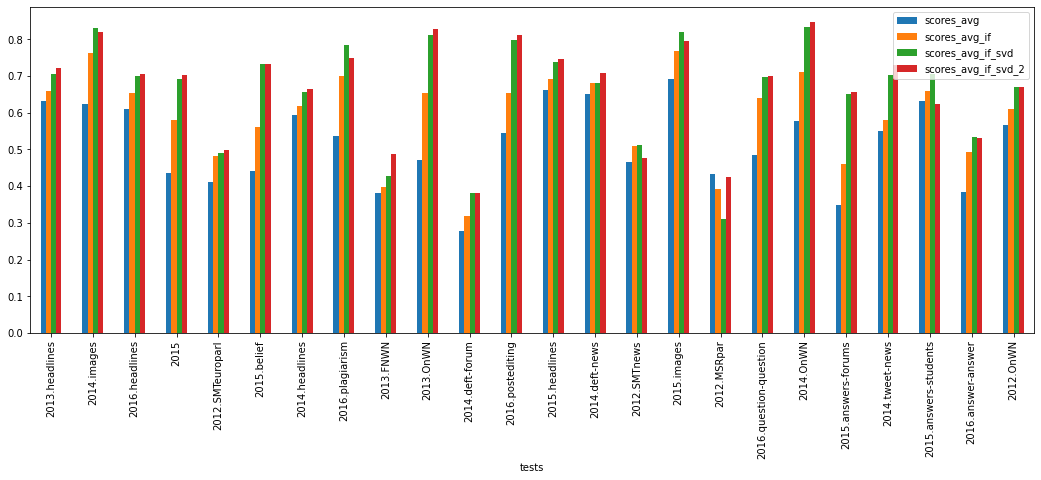

In [ ]:
df.plot.bar(x='tests', rot=90, figsize=(18, 6))

##Final Comment

In the present exercise we learned two classes of methods for evaluating embeddings $-$ extrinsic and intrinsic. Extrinsic methods use the embeddings as building blocks for a downstream task (e.g., sentiment analysis, classification, etc.). Intrinsic ones explore the embedding space in order to measure some useful linguistic phenomena. The method you have master in the present exercise is of the intrinsic class.